In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


Loaded MNIST: 60000 samples
Image shape: (28, 28) | Label: 0


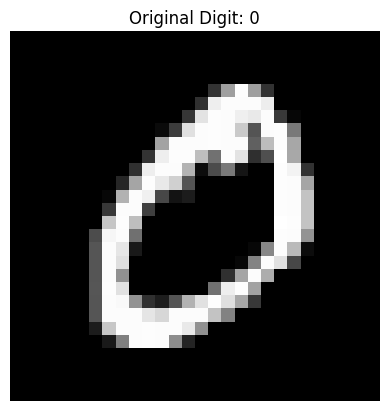

In [2]:
# Load MNIST (28x28 grayscale)
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist = datasets.MNIST(root="mnist", train=True, download=False, transform=transform)
print("Loaded MNIST:", len(mnist), "samples")

# Pick one image
idx = 1
image, label = mnist[idx]
image = image.squeeze().numpy()
print("Image shape:", image.shape, "| Label:", label)

plt.imshow(image, cmap='gray')
plt.title(f"Original Digit: {label}")
plt.axis('off')
plt.show()


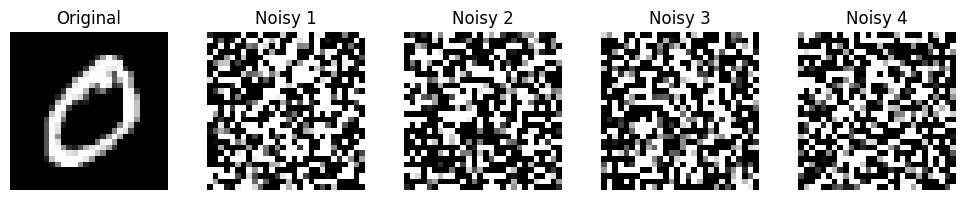

In [3]:
def add_gaussian_noise(img, mean=0, std=0.5):
    timesteps = 10
    for _ in range(timesteps):
        std = random.uniform(2, std)
        noise = np.random.normal(mean, std, img.shape)
        noisy = img + noise
    return np.clip(noisy, 0.0, 1.0)

# Generate 4 noisy versions of the same image, varying std
noisy_versions = [add_gaussian_noise(image, std=2) for _ in range(4)]

plt.figure(figsize=(10, 2))
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis('off')

for i, n in enumerate(noisy_versions):
    plt.subplot(1, 5, i+2)
    plt.imshow(n, cmap='gray')
    plt.title(f"Noisy {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


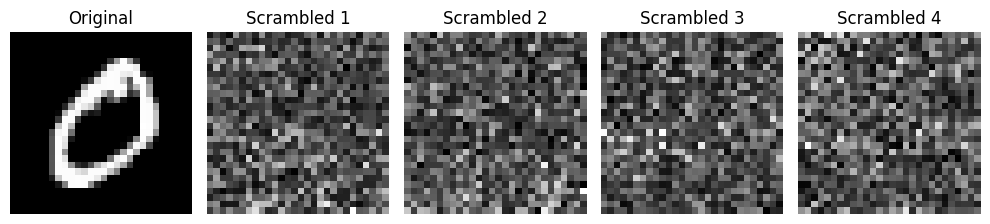

In [17]:
from utils.haar_noising_script import fast_haar_scramble
from utils.angle_encoding_script import angle_encoding


def pad_to_power_of_two(vec, n_qubits):
    dim = 2 ** n_qubits
    v = np.copy(vec)
    if len(v) < dim:
        v = np.pad(v, (0, dim - len(v)), mode='constant')
    else:
        v = v[:dim]
    # normalize to unit norm
    v = v / np.linalg.norm(v)
    return v


num_samples = 10
num_scrambles = 4
n_qubits = 10
depth = 8
seed = 42

encoded_images = []
scrambled_versions_all = []
mnist_chunk = np.array([mnist[i][0].squeeze() for i in range(num_samples)])

for s in range(num_samples):
    encoded = angle_encoding(mnist_chunk, sample=s)
    encoded_images.append(encoded)

    # Flatten encoded image and pad/truncate (if dimension is not a power of 2)
    flat_encoded = encoded.flatten()
    flat_encoded = pad_to_power_of_two(flat_encoded, n_qubits)

    # Apply Haar scrambling (or the fast haar-like circuit) multiple times
    scrambles = [
        fast_haar_scramble(flat_encoded, n_qubits=n_qubits, depth=depth, seed=seed + k)
        for k in range(num_scrambles)
    ]
    scrambled_versions_all.append(scrambles)

# Visualize by sample
sample_idx = 1
original_image = mnist_chunk[sample_idx]

plt.figure(figsize=(10, 2.5))
plt.subplot(1, num_scrambles + 1, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original")
plt.axis("off")

for i, scrambled_state in enumerate(scrambled_versions_all[sample_idx]):
    scrambled_img = np.abs(scrambled_state[:28*28]).reshape(28, 28)
    plt.subplot(1, num_scrambles + 1, i + 2)
    plt.imshow(scrambled_img, cmap="gray")
    plt.title(f"Scrambled {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Scrambled dataset: (100, 784) Targets: (100, 784)
Training quantum diffusion model...
Epoch 1/10 - Train: 0.96765 | Val: 0.96920
Epoch 2/10 - Train: 0.95627 | Val: 0.95774
Epoch 3/10 - Train: 0.94499 | Val: 0.94636
Epoch 4/10 - Train: 0.93380 | Val: 0.93508
Epoch 5/10 - Train: 0.92275 | Val: 0.92393
Epoch 6/10 - Train: 0.91175 | Val: 0.91297
Epoch 7/10 - Train: 0.90104 | Val: 0.90216
Epoch 8/10 - Train: 0.89044 | Val: 0.89157
Epoch 9/10 - Train: 0.88007 | Val: 0.88120
Epoch 10/10 - Train: 0.86990 | Val: 0.87110
Training finished in 716.61s

FID: 685.3380, SSIM: 0.0002


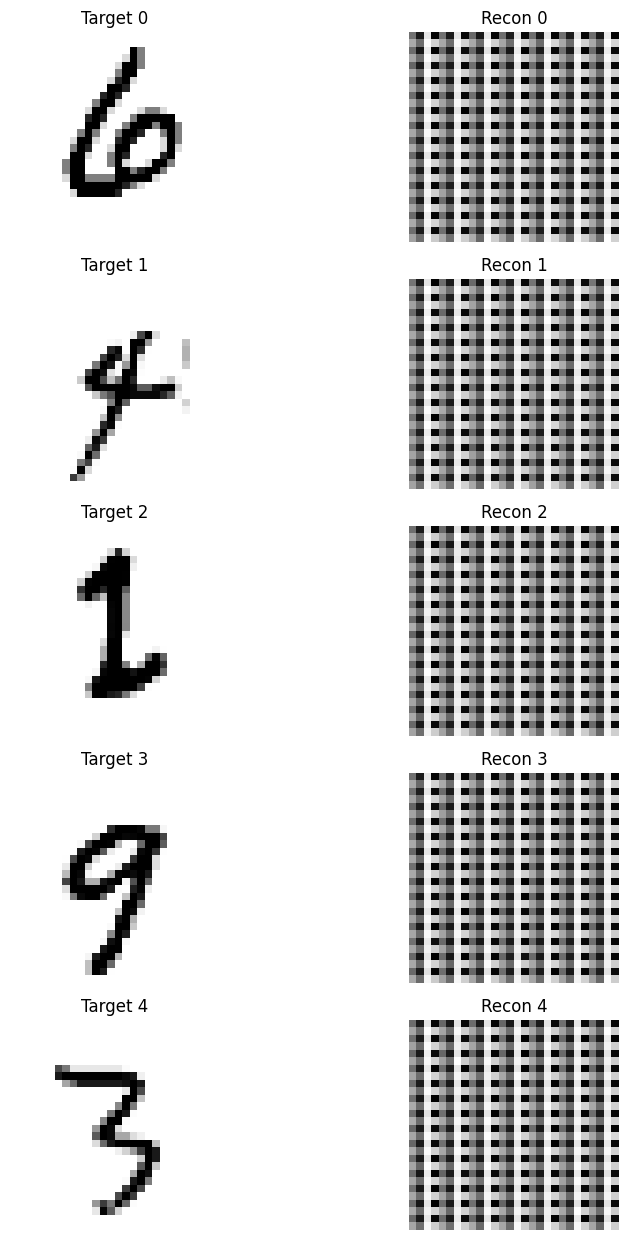

In [18]:
# === Quantum Diffusion Training with Haar-scrambled MNIST ===
import torch
from utils.haar_noising_script import fast_haar_scramble
from utils.angle_encoding_script import angle_encoding
from utils.quantum_diffusion import QuantumDiffusionModel, calculate_statistics, calculate_fid, calculate_ssim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

# ----------------------------
# Parameters
# ----------------------------
num_samples = 100
num_scrambles = 1
n_qubits_scramble = 10
scramble_depth = 8
seed = 42

# model params
n_qubits = 8
n_layers = 6
hidden_dim = 128
num_epochs = 10
batch_size = 16
lr = 1e-3

np.random.seed(seed)
torch.manual_seed(seed)

# ----------------------------
# Helper: pad/truncate to power of two
# ----------------------------
def pad_to_power_of_two(vec, n_qubits):
    """Pad or truncate vector to 2**n_qubits."""
    dim = 2 ** n_qubits
    v = np.copy(vec)
    if len(v) < dim:
        v = np.pad(v, (0, dim - len(v)), mode="constant")
    else:
        v = v[:dim]
    v = v / np.linalg.norm(v)
    return v

# ----------------------------
# Load MNIST subset and encode
# ----------------------------
mnist_chunk = np.array([mnist[i][0].squeeze() for i in range(num_samples)])  # shape (N,28,28)
encoded_images = []
scrambled_versions_all = []

for s in range(num_samples):
    encoded = angle_encoding(mnist_chunk, sample=s)  # (14,14,4)
    encoded_images.append(encoded)

    flat_encoded = encoded.flatten()
    flat_encoded = pad_to_power_of_two(flat_encoded, n_qubits_scramble)

    scrambles = [
        fast_haar_scramble(flat_encoded, n_qubits=n_qubits_scramble, depth=scramble_depth, seed=seed + k)
        for k in range(num_scrambles)
    ]
    scrambled_versions_all.append(scrambles)

encoded_images = np.array(encoded_images)                   # shape (num_samples,14,14,4)
input_dim = np.prod(encoded_images.shape[1:])               # 14*14*4 = 784

# ----------------------------
# Build many-to-one dataset
# ----------------------------
scrambled_flat = []
targets_flat = []

for i in range(num_samples):
    for j in range(num_scrambles):
        scrambled = np.abs(scrambled_versions_all[i][j][:input_dim])  # trim/pad to match
        scrambled_flat.append(scrambled)
        targets_flat.append(encoded_images[i].flatten())

scrambled_flat = np.array(scrambled_flat)
targets_flat = np.array(targets_flat)

print("Scrambled dataset:", scrambled_flat.shape, "Targets:", targets_flat.shape)

# ----------------------------
# Split data
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(scrambled_flat, targets_flat, test_size=0.15, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)

# ----------------------------
# Train Quantum Diffusion Model
# ----------------------------
device = torch.device("cpu")
model = QuantumDiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=input_dim,
                              n_qubits=n_qubits, n_layers=n_layers)
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print("Training quantum diffusion model...")
train_losses, val_losses = [], []
start = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f}")

print("Training finished in {:.2f}s".format(time.time() - start))

# ----------------------------
# Evaluation and reconstruction
# ----------------------------
def decode_to_28x28(flat_batch):
    """Decode 14x14x4 back to 28x28 grayscale."""
    B = flat_batch.shape[0]
    patches = flat_batch.reshape(B, 14, 14, 4)
    decoded = np.zeros((B, 28, 28))
    for n in range(B):
        for i in range(14):
            for j in range(14):
                c0, c1, c2, c3 = patches[n, i, j]
                decoded[n, 2*i, 2*j]     = c0
                decoded[n, 2*i, 2*j+1]   = c1
                decoded[n, 2*i+1, 2*j]   = c2
                decoded[n, 2*i+1, 2*j+1] = c3
    return decoded

model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        all_preds.append(out)
        all_true.append(yb.numpy())

all_preds = np.vstack(all_preds)
all_true = np.vstack(all_true)

decoded_preds = decode_to_28x28(all_preds)
decoded_true = decode_to_28x28(all_true)

# Compute FID + SSIM
mu_real, sigma_real = calculate_statistics(decoded_true)
mu_fake, sigma_fake = calculate_statistics(decoded_preds)
fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
ssim_score = calculate_ssim(decoded_true, decoded_preds)
print(f"\nFID: {fid_score:.4f}, SSIM: {ssim_score:.4f}")

# ----------------------------
# Visualization
# ----------------------------
n_show = min(5, len(decoded_preds))
plt.figure(figsize=(10, 2.5*n_show))
for i in range(n_show):
    plt.subplot(n_show, 2, 2*i + 1)
    plt.imshow(decoded_true[i], cmap='gray')
    plt.title(f"Target {i}")
    plt.axis("off")

    plt.subplot(n_show, 2, 2*i + 2)
    plt.imshow(decoded_preds[i], cmap='gray')
    plt.title(f"Recon {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [19]:
# ---- Save model ----
torch.save(model.state_dict(), "saved_models/mnist_qdiff1_model.pt")
print("Model saved to saved_models/mnist_qdiff1_model.pt")

Model saved to saved_models/mnist_qdiff1_model.pt


Scrambled dataset: (400, 784) Targets: (400, 784)
Training quantum diffusion model...
Epoch 1/10 - Train: 0.95130 | Val: 0.92583
Epoch 2/10 - Train: 0.90673 | Val: 0.88358
Epoch 3/10 - Train: 0.86500 | Val: 0.84495
Epoch 4/10 - Train: 0.82764 | Val: 0.81109
Epoch 5/10 - Train: 0.79501 | Val: 0.78163
Epoch 6/10 - Train: 0.76664 | Val: 0.75618
Epoch 7/10 - Train: 0.74235 | Val: 0.73458
Epoch 8/10 - Train: 0.72187 | Val: 0.71675
Epoch 9/10 - Train: 0.70486 | Val: 0.70165
Epoch 10/10 - Train: 0.69030 | Val: 0.68849
Training finished in 6935.04s

FID: 539.2407, SSIM: 0.0013


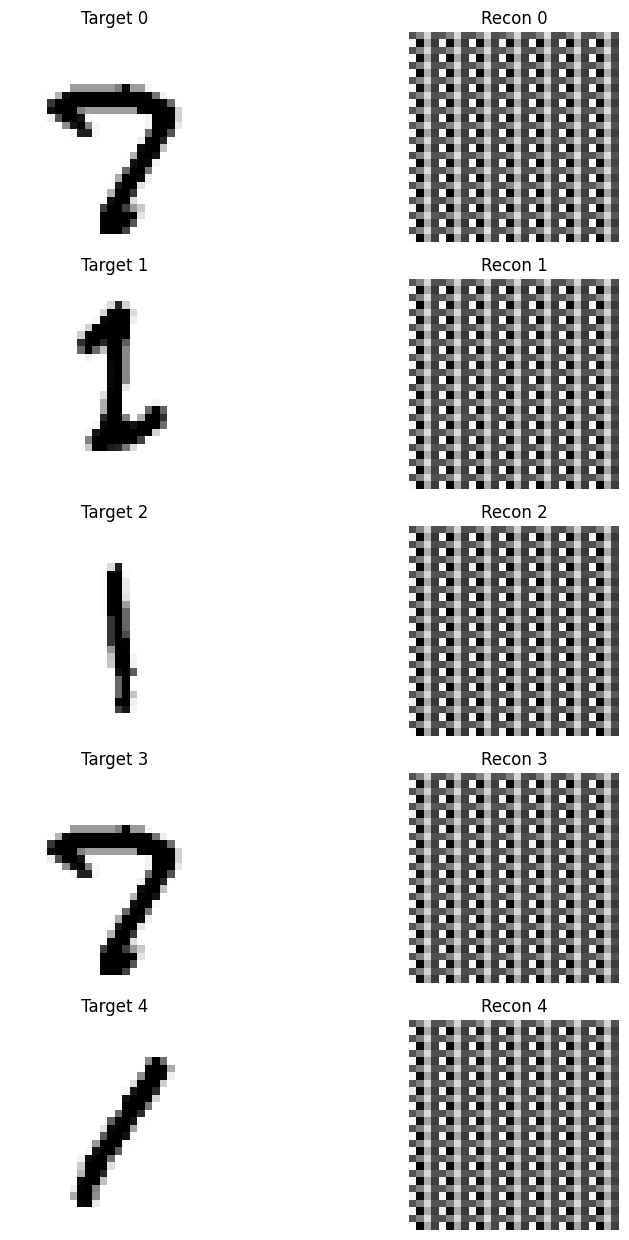

Model saved to saved_models/mnist_qdiff4_model.pt


In [21]:
# ----------------------------
# Parameters
# ----------------------------
num_scrambles = 4

np.random.seed(seed)
torch.manual_seed(seed)

# ----------------------------
# Load MNIST subset and encode
# ----------------------------
mnist_chunk = np.array([mnist[i][0].squeeze() for i in range(num_samples)])  # shape (N,28,28)
encoded_images = []
scrambled_versions_all = []

for s in range(num_samples):
    encoded = angle_encoding(mnist_chunk, sample=s)  # (14,14,4)
    encoded_images.append(encoded)

    flat_encoded = encoded.flatten()
    flat_encoded = pad_to_power_of_two(flat_encoded, n_qubits_scramble)

    scrambles = [
        fast_haar_scramble(flat_encoded, n_qubits=n_qubits_scramble, depth=scramble_depth, seed=seed + k)
        for k in range(num_scrambles)
    ]
    scrambled_versions_all.append(scrambles)

encoded_images = np.array(encoded_images)                   # shape (num_samples,14,14,4)
input_dim = np.prod(encoded_images.shape[1:])               # 14*14*4 = 784

# ----------------------------
# Build many-to-one dataset
# ----------------------------
scrambled_flat = []
targets_flat = []

for i in range(num_samples):
    for j in range(num_scrambles):
        scrambled = np.abs(scrambled_versions_all[i][j][:input_dim])  # trim/pad to match
        scrambled_flat.append(scrambled)
        targets_flat.append(encoded_images[i].flatten())

scrambled_flat = np.array(scrambled_flat)
targets_flat = np.array(targets_flat)

print("Scrambled dataset:", scrambled_flat.shape, "Targets:", targets_flat.shape)

# ----------------------------
# Split data
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(scrambled_flat, targets_flat, test_size=0.15, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)

# ----------------------------
# Train Quantum Diffusion Model
# ----------------------------
device = torch.device("cpu")
model = QuantumDiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=input_dim,
                              n_qubits=n_qubits, n_layers=n_layers)
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print("Training quantum diffusion model...")
train_losses, val_losses = [], []
start = time.time()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train: {avg_train_loss:.5f} | Val: {avg_val_loss:.5f}")

print("Training finished in {:.2f}s".format(time.time() - start))

model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        all_preds.append(out)
        all_true.append(yb.numpy())

all_preds = np.vstack(all_preds)
all_true = np.vstack(all_true)

decoded_preds = decode_to_28x28(all_preds)
decoded_true = decode_to_28x28(all_true)

# Compute FID + SSIM
mu_real, sigma_real = calculate_statistics(decoded_true)
mu_fake, sigma_fake = calculate_statistics(decoded_preds)
fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
ssim_score = calculate_ssim(decoded_true, decoded_preds)
print(f"\nFID: {fid_score:.4f}, SSIM: {ssim_score:.4f}")

# ----------------------------
# Visualization
# ----------------------------
n_show = min(5, len(decoded_preds))
plt.figure(figsize=(10, 2.5*n_show))
for i in range(n_show):
    plt.subplot(n_show, 2, 2*i + 1)
    plt.imshow(decoded_true[i], cmap='gray')
    plt.title(f"Target {i}")
    plt.axis("off")

    plt.subplot(n_show, 2, 2*i + 2)
    plt.imshow(decoded_preds[i], cmap='gray')
    plt.title(f"Recon {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# ---- Save model ----
torch.save(model.state_dict(), "saved_models/mnist_qdiff4_model.pt")
print("Model saved to saved_models/mnist_qdiff4_model.pt")